# Identifying Types of Beans with K-Means Clustering

## Load and Preview the Data

In [947]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

data = pd.read_csv("/Users/amanserhan/clustering-beans/Dry_Bean_Dataset.csv")
print('Bean Types: ', data["Class"].unique())
data.head()

Bean Types:  ['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


There are seven types of dry beans in the dataset, and 16 features describing the appearance and shape of each bean in the data frame. We will be using k-means clustering, an unsupervised machine learning model, to group our beans in 7 clusters, one for each type, based on the features in our dataset. Based on this we can use the model to predict the type of new, inclassified beans given a picture of the bean. 
16 features is a lot to start with, so let's fit our model on a subset of these features and iterate on this subset as needed.
The features we will start with are:
1. Perimeter (length of the border of the bean)
2. AspectRatio (the ratio between the length and width of the bean)
3. Eccentricity (eccentricity of the ellipse)

## Analysis and Modelling

In [950]:
# Renaming inconsistentc column titles
data = data.rename({"AspectRation":"AspectRatio", "roundness": "Roundness"}, axis=1)

# Creating a new data frame with the selected features
samples = data[["Perimeter", "AspectRatio", "Eccentricity"]]

# Creating and fitting the K-Means clustering model, setting the "init" parameter to k-means++
model = KMeans(init='k-means++', n_clusters=7, random_state=1)
model.fit(samples)

# Creating variables for the model's predictions and the solutions (target variable)
target = data["Class"]
labels = model.predict(samples)

Let's graph our clusters on a 3D axis to visualize our results.

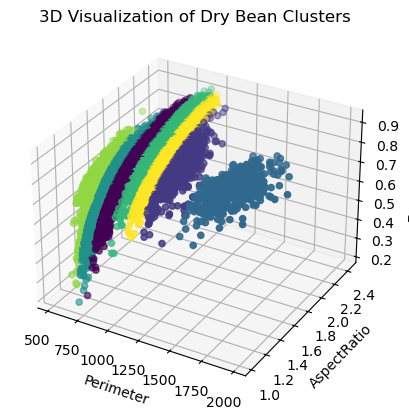

In [952]:
# Plotting in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(samples['Perimeter'], samples['AspectRatio'], samples['Eccentricity'], c=labels, cmap='viridis')

# Labeling the axes
ax.set_xlabel('Perimeter')
ax.set_ylabel('AspectRatio')
ax.set_zlabel('Eccentricity')

plt.title('3D Visualization of Dry Bean Clusters')
plt.show()

### Model Evaluation

Before we evaluate the model, we need to map our clusters to a bean type so we can use this mapping for our homogeneity, completeness and v-measure scores, in addition to the confusion matrix, all of which leverage our target data. We will do this by mapping the majority class in within each cluster to its corresponding bean label.

In [955]:
from collections import Counter

# Creating a DataFrame with sample data and predicted labels
results = pd.DataFrame({'Feature1': samples['Perimeter'], 
                        'Feature2': samples['AspectRatio'], 
                        'Feature3': samples['Eccentricity'],
                        'TrueClass': target,
                        'PredictedCluster': labels})

# Determining the majority class for each cluster
cluster_to_class = {}
for cluster in results['PredictedCluster'].unique():
    cluster_data = results[results['PredictedCluster'] == cluster]
    most_common_class = Counter(cluster_data['TrueClass']).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class

print("Cluster to Bean Type Mapping:", cluster_to_class)

# Comparing the majority cluster to the counts of each bean in the cluster
for cluster in results['PredictedCluster'].unique():
    print("Cluster: ", cluster, cluster_to_class[cluster])
    print(results[results['PredictedCluster'] == cluster]['TrueClass'].value_counts())


Cluster to Bean Type Mapping: {5: 'DERMASON', 3: 'DERMASON', 0: 'SIRA', 4: 'HOROZ', 6: 'CALI', 1: 'CALI', 2: 'BOMBAY'}
Cluster:  5 DERMASON
TrueClass
DERMASON    2014
SEKER        226
SIRA           6
Name: count, dtype: int64
Cluster:  3 DERMASON
TrueClass
DERMASON    1473
SEKER       1358
SIRA         541
HOROZ         42
BARBUNYA       1
Name: count, dtype: int64
Cluster:  0 SIRA
TrueClass
SIRA        1893
SEKER        415
HOROZ        296
DERMASON      58
BARBUNYA      28
CALI           5
Name: count, dtype: int64
Cluster:  4 HOROZ
TrueClass
HOROZ       1145
BARBUNYA     222
SIRA         195
CALI         137
SEKER         28
DERMASON       1
Name: count, dtype: int64
Cluster:  6 CALI
TrueClass
CALI        917
BARBUNYA    611
HOROZ       426
SIRA          1
Name: count, dtype: int64
Cluster:  1 CALI
TrueClass
CALI        571
BARBUNYA    460
HOROZ        19
BOMBAY        8
Name: count, dtype: int64
Cluster:  2 BOMBAY
TrueClass
BOMBAY    514
Name: count, dtype: int64


Before we even get to evaluation metrics, we can tell there's a problem with how our model is clustering the data because there are 2 pairs of clusters with the same majority class, even though we know there are seven different bean types. 
This issue could also be caused by the uneven distribution of bean types in the dataset. If one bean type has a significantly larger representation in the data, the K-Means algorithm might create multiple clusters that predominantly contain this bean type. This can result in the majority class for more than one cluster being the same bean type, leading to multiple clusters being mapped to the same bean type.

To determine if this is the problem, let's see how many of each bean type we have in the target column.

In [957]:
# Count the number of instances of each bean type in the target column
bean_counts = target.value_counts()
print(bean_counts)

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64


It appears that Dermason is the most common type of bean in the dataset, which is consistent with the fact that two clusters have a majority of Dermaosn beans. It is curious that Cali is the third least common bean type, yet is the majority bean in two clusters. Although in both clusters mapped to Cali, the second most common bean is Barbunya, which is the second least common bean that doesn't have its own cluster. This may suggest that Cali and Barbunya beans are quite similar. Another interesting finding is that Bombay, the least common bean type with 522 total points in the dataset, has its own cluster where 514 Bombay points, and no other points, are in the cluster. This suggests that Bombay beans are very distinct, and so they're getting classified correctly despite being the least commonly occurring bean in the dataset.

Before we can map our clusters to numbers and calculate our evaluation metrics, we need to improve our model so that at the very least, there's a different majority bean in each of our seven clusters. We'll do this by trying out different feature combinations and scaling the features since some of the features have different scales, which may have negatively affected the results the first time around. We will use z-score normalization for this.

Note that because we will likely try multiple different combinations of features, we'll create a function that scales the features, creates and fits the model, maps each cluster to its majority class, and counts instances of each bean in each cluster. This will prevent us from having to copy and paste large blocks of code for each feature combination we try.

In [959]:
from sklearn.preprocessing import StandardScaler

# Defining a function to create the model and view the results
def fit_map(data, features, cluster_n = 7):
    
    # Creating a new data frame with the selected features
    samples = data[features]
    
     # Scaling the features
    scaler = StandardScaler()  
    scaled_samples = scaler.fit_transform(samples)
    
    # Creating and fitting the K-Means clustering model, setting the "init" parameter to k-means++
    model = KMeans(init='k-means++', n_clusters=cluster_n, random_state=1)
    model.fit(scaled_samples)

    # Creating a target variable and a variable for the model's predictions
    target = data["Class"]
    labels = model.predict(scaled_samples)
    
    # Mapping a bean type to each cluster based on the majority class
    results = pd.DataFrame({'TrueClass': target,
                            'PredictedCluster': labels})
    for i, feature in enumerate(features):
        results[f'Feature{i}'] = scaled_samples[:, i]
        
    # Determining the majority class for each cluster
    cluster_to_class = {}
    for cluster in results['PredictedCluster'].unique():
        cluster_data = results[results['PredictedCluster'] == cluster]
        most_common_class = Counter(cluster_data['TrueClass']).most_common(1)[0][0]
        cluster_to_class[cluster] = most_common_class
    
    print("Cluster to Bean Type Mapping:", cluster_to_class)

    # Comparing the majority cluster to the counts of each bean in the cluster
    for cluster in results['PredictedCluster'].unique():
        print("Cluster: ", cluster, cluster_to_class[cluster])
        print(results[results['PredictedCluster'] == cluster]['TrueClass'].value_counts())
        
    # Flipping keys and values for the cluster to class mapping so it can be used later to convert the target column to an integer column for evaluation
    string_to_int = {value: key for key, value in cluster_to_class.items()}
    print("String Target to Integer Mapping :", string_to_int)
    
    return scaled_samples,results,string_to_int

Note that this function is not completely generalized and has some static parameters, like the number of clusters and the naming of the target column in the data frame. It is general enough, however, that we can try out different features without needing to copy and paste all of the code again. Let's first try keeping the same features and seeing if the introduction of feature scaling alone positively impacts the results. 

In [961]:
features = ["Perimeter", "AspectRatio", "Eccentricity"]
scaled_samples, results, string_to_int = fit_map(data, features);

Cluster to Bean Type Mapping: {6: 'SEKER', 2: 'SEKER', 4: 'DERMASON', 1: 'SIRA', 5: 'CALI', 0: 'HOROZ', 3: 'BOMBAY'}
Cluster:  6 SEKER
TrueClass
SEKER       1068
DERMASON      12
BARBUNYA       9
Name: count, dtype: int64
Cluster:  2 SEKER
TrueClass
SEKER       860
DERMASON    361
BARBUNYA    160
SIRA         58
CALI          2
BOMBAY        1
Name: count, dtype: int64
Cluster:  4 DERMASON
TrueClass
DERMASON    2452
SIRA         773
SEKER         78
BARBUNYA      28
CALI           5
HOROZ          3
Name: count, dtype: int64
Cluster:  1 SIRA
TrueClass
SIRA        1764
DERMASON     717
BARBUNYA      95
HOROZ         87
CALI          26
SEKER         21
Name: count, dtype: int64
Cluster:  5 CALI
TrueClass
CALI        1501
BARBUNYA    1018
HOROZ         70
SIRA          16
Name: count, dtype: int64
Cluster:  0 HOROZ
TrueClass
HOROZ       1768
CALI          96
SIRA          25
BARBUNYA       9
DERMASON       4
Name: count, dtype: int64
Cluster:  3 BOMBAY
TrueClass
BOMBAY      521
BARBUNYA 

There's been some improvement for some of our clusters, but not all. We're now seeing Seker being the majority bean in two clusters. In the first cluster where Seker is the majority, the results look pretty good, with few non-Seker points in the cluster. But the second one has a decent number of Dermason and Barbunya points, which suggests they could have similar properties in the features we've selected. So let's add one more feature in and see if that can help the model further distinguish between these bean types. To make an informed decision, let's look at some pictures of Seker, Dermason and Barbunya beans online and see if we can identify a differentiating property between them among the columns in our dataset. 

Upon looking at pictures of the three bean types, it is clear why the model is having a hard time distinguishing them. The shape of the three beans is pretty similar. One notable difference, however, is the roundness of the beans. Some appear to be more oval than others. This could be useful in improving our results, so let's add in "Roundness" as a fourth feature.

In [963]:
features = ["Perimeter", "AspectRatio", "Eccentricity", "Roundness"]
scaled_samples, results, string_to_int = fit_map(data, features);

Cluster to Bean Type Mapping: {4: 'SEKER', 1: 'DERMASON', 3: 'BARBUNYA', 5: 'SIRA', 2: 'CALI', 0: 'HOROZ', 6: 'BOMBAY'}
Cluster:  4 SEKER
TrueClass
SEKER       1661
DERMASON      79
BARBUNYA      12
SIRA           4
BOMBAY         1
CALI           1
Name: count, dtype: int64
Cluster:  1 DERMASON
TrueClass
DERMASON    2292
SIRA         481
SEKER        314
BARBUNYA      20
CALI           2
HOROZ          2
Name: count, dtype: int64
Cluster:  3 BARBUNYA
TrueClass
BARBUNYA    924
DERMASON     30
SEKER        24
SIRA         12
HOROZ         5
CALI          3
Name: count, dtype: int64
Cluster:  5 SIRA
TrueClass
SIRA        1968
DERMASON    1138
BARBUNYA      87
CALI          51
HOROZ         41
SEKER         27
Name: count, dtype: int64
Cluster:  2 CALI
TrueClass
CALI        1516
BARBUNYA     257
SIRA         162
HOROZ        142
SEKER          1
Name: count, dtype: int64
Cluster:  0 HOROZ
TrueClass
HOROZ       1738
CALI          57
BARBUNYA      22
SIRA           9
DERMASON       7
Name: 

There is a significant improvement in our results since now each cluster has a different majority class, which means we can map a bean type to each cluster. However, the homogeneity of some clusters is not looking very good, especially the "Sira" cluster. But now that we have a unique mapping for each cluster, we can calculate the evaluation metrics for a clearer assessment of the results.

In [965]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score, confusion_matrix

# Create a new column in the results DataFrame with integer labels for the true classes
results['TrueClassInteger'] = results['TrueClass'].map(string_to_int)

db_index = davies_bouldin_score(scaled_samples, results['PredictedCluster'])
score = silhouette_score(scaled_samples, results['PredictedCluster'])
ari = adjusted_rand_score(results['TrueClassInteger'], results['PredictedCluster'])
homog = homogeneity_score(results['TrueClassInteger'], results['PredictedCluster'])
comp = completeness_score(results['TrueClassInteger'], results['PredictedCluster'])
v_measure = v_measure_score(results['TrueClassInteger'], results['PredictedCluster'])
conf_matrix = confusion_matrix(results['TrueClassInteger'], results['PredictedCluster'])


print('Davies-Bouldin Index: ', db_index)
print('Silhouette Score: ', score)
print('Adjusted Rand Index:' ,ari)
print('Homogeneity Score: ', homog)
print('Completeness Score: ', comp)
print('V-Measure Score: ', v_measure)
print('Confusion Matrix:\n', conf_matrix)

Davies-Bouldin Index:  0.8603932027579203
Silhouette Score:  0.39834029686153805
Adjusted Rand Index: 0.5406344825330066
Homogeneity Score:  0.6547319325129523
Completeness Score:  0.660292498503371
V-Measure Score:  0.6575004591128413
Confusion Matrix:
 [[1738    2  142    5    0   41    0]
 [   7 2292    0   30   79 1138    0]
 [  57    2 1516    3    1   51    0]
 [  22   20  257  924   12   87    0]
 [   0  314    1   24 1661   27    0]
 [   9  481  162   12    4 1968    0]
 [   0    0    0    0    1    0  521]]


Based on these metrics, the model shows moderate performance. While the homogeneity, completeness, and V-Measure scores are in the mid-60s, indicating a good but not perfect clustering, the ARI suggests moderate alignment with the true classes. The Silhouette Score indicates that the clusters are somewhat distinct but could be better separated.
The confusion matrix shows that while some clusters align well with the true classes, there are also significant misclassifications, especially in clusters 1 and 5.
In a since-removed block of code, different combinations of features were experimented with, but none of these combinations feature any significant improvement to the mode. Instead, let's try performing principle component analysis (PCA) with all the available features in order to retain the few with the most variance and therefore the most valuable information for our model.

In [968]:
from sklearn.decomposition import PCA

all_features = data.drop("Class", axis = 1)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(all_features)

# Initialize PCA (starting with all the components to begin with, then adjusting based on the explained variance)
pca = PCA(n_components=len(all_features.columns)) 
pca_data = pca.fit_transform(scaled_data)

# Check the explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Print explained variance
print("Explained variance by each component: ", explained_variance)
print("Cumulative explained variance: ", cumulative_explained_variance)

Explained variance by each component:  [5.54664386e-01 2.64309732e-01 8.00656422e-02 5.11408029e-02
 2.73929290e-02 1.14976093e-02 6.97650724e-03 3.25082500e-03
 5.16266295e-04 9.08681206e-05 6.58867938e-05 1.83739336e-05
 9.29966038e-06 6.25641678e-07 1.34132086e-07 1.11549485e-07]
Cumulative explained variance:  [0.55466439 0.81897412 0.89903976 0.95018056 0.97757349 0.9890711
 0.99604761 0.99929843 0.9998147  0.99990557 0.99997146 0.99998983
 0.99999913 0.99999975 0.99999989 1.        ]


It looks like if we keep the first six principal components we would be capturing around 99% of the variance in the data, so let's fit a model on these components and re-examine our evaluation metrics. 

In [970]:
# Re-running PCA with 6 principal components
pca = PCA(n_components=6)
pca_data = pca.fit_transform(scaled_data)

model = KMeans(init='k-means++', n_clusters=7, random_state=1)
model.fit(pca_data)
target = data['Class']

labels = model.predict(pca_data)

# Mapping a bean type to each cluster based on majority class
results = pd.DataFrame({'TrueClass': target,
                            'PredictedCluster': labels})
for i, feature in enumerate(features):
    results[f'Feature{i}'] = pca_data[:, i]
        
# Determining the majority class for each cluster
cluster_to_class = {}
for cluster in results['PredictedCluster'].unique():
    cluster_data = results[results['PredictedCluster'] == cluster]
    most_common_class = Counter(cluster_data['TrueClass']).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class
    
print("Cluster to Bean Type Mapping:", cluster_to_class)

# Comparing the majority cluster to the counts of each bean in the cluster
for cluster in results['PredictedCluster'].unique():
    print("Cluster: ", cluster, cluster_to_class[cluster])
    print(results[results['PredictedCluster'] == cluster]['TrueClass'].value_counts())
    
# Flipping keys and values for the cluster to class mapping so it can be used to convert the target column to an integer column for evaluation
string_to_int = {value: key for key, value in cluster_to_class.items()}
print("String Target to Integer Mapping :", string_to_int)

Cluster to Bean Type Mapping: {2: 'SEKER', 5: 'DERMASON', 6: 'CALI', 1: 'SIRA', 0: 'HOROZ', 4: 'CALI', 3: 'BOMBAY'}
Cluster:  2 SEKER
TrueClass
SEKER       1879
DERMASON     119
SIRA          27
BARBUNYA      18
CALI           2
Name: count, dtype: int64
Cluster:  5 DERMASON
TrueClass
DERMASON    2915
SIRA         186
SEKER         48
HOROZ          2
Name: count, dtype: int64
Cluster:  6 CALI
TrueClass
CALI        269
HOROZ       198
BARBUNYA     40
SIRA         27
DERMASON     13
SEKER         3
BOMBAY        1
Name: count, dtype: int64
Cluster:  1 SIRA
TrueClass
SIRA        2319
DERMASON     492
BARBUNYA     113
SEKER         97
HOROZ         49
CALI          25
Name: count, dtype: int64
Cluster:  0 HOROZ
TrueClass
HOROZ       1650
SIRA          73
CALI          31
BARBUNYA       8
DERMASON       7
Name: count, dtype: int64
Cluster:  4 CALI
TrueClass
CALI        1303
BARBUNYA    1143
HOROZ         29
SIRA           4
BOMBAY         1
Name: count, dtype: int64
Cluster:  3 BOMBAY
True

Unfortunately, with PCA, we're back to our original issue of two clusters having the same majority bean type. As we identified earlier, Barbunya beans and California beans are very similar in appearance, which explains why the models is having such a hard time distinguishing between them. However, the results look better for the other bean types, presenting a tradeoff between improving the model's overall accuracy or its ability to differentiate between these two beans. If our priority is improving the overall accuracy, one of the paths we can take is reducing the number of clusters in the model to 6, so that Barbunya and California beans get grouped into the same cluster. Let's try this and evaluate if sacrificing the differentiation between the two types is worth it.

In [972]:
# Creating and fitting the model
model = KMeans(init='k-means++', n_clusters=6, random_state=1)
model.fit(pca_data)
target = data['Class']

# Generating the model's predictions
labels = model.predict(pca_data)

# Mapping a bean type to each cluster based on majority class
results = pd.DataFrame({'TrueClass': target,
                            'PredictedCluster': labels})
for i, feature in enumerate(features):
    results[f'Feature{i}'] = pca_data[:, i]
        
# Determining the majority class for each cluster
cluster_to_class = {}
for cluster in results['PredictedCluster'].unique():
    cluster_data = results[results['PredictedCluster'] == cluster]
    most_common_class = Counter(cluster_data['TrueClass']).most_common(1)[0][0]
    cluster_to_class[cluster] = most_common_class
    
print("Cluster to Bean Type Mapping:", cluster_to_class)

# Comparing the majority cluster to the counts of each bean in the cluster
for cluster in results['PredictedCluster'].unique():
    print("Cluster: ", cluster, cluster_to_class[cluster])
    print(results[results['PredictedCluster'] == cluster]['TrueClass'].value_counts())
    
# Flipping keys and values for the cluster to class mapping so it can be used to convert the target column to an integer column for evaluation
string_to_int = {value: key for key, value in cluster_to_class.items()}
print("String Target to Integer Mapping :", string_to_int)

Cluster to Bean Type Mapping: {2: 'SEKER', 5: 'DERMASON', 4: 'CALI', 1: 'SIRA', 0: 'HOROZ', 3: 'BOMBAY'}
Cluster:  2 SEKER
TrueClass
SEKER       1879
DERMASON     119
SIRA          27
BARBUNYA      21
CALI           2
Name: count, dtype: int64
Cluster:  5 DERMASON
TrueClass
DERMASON    2944
SIRA         199
SEKER         50
HOROZ          2
Name: count, dtype: int64
Cluster:  4 CALI
TrueClass
CALI        1551
BARBUNYA    1143
HOROZ         66
SIRA          13
SEKER          3
BOMBAY         1
DERMASON       1
Name: count, dtype: int64
Cluster:  1 SIRA
TrueClass
SIRA        2317
DERMASON     472
BARBUNYA     146
SEKER         95
HOROZ         56
CALI          39
Name: count, dtype: int64
Cluster:  0 HOROZ
TrueClass
HOROZ       1804
SIRA          80
CALI          38
BARBUNYA      12
DERMASON      10
Name: count, dtype: int64
Cluster:  3 BOMBAY
TrueClass
BOMBAY    521
Name: count, dtype: int64
String Target to Integer Mapping : {'SEKER': 2, 'DERMASON': 5, 'CALI': 4, 'SIRA': 1, 'HOROZ': 0,

Right away we're seeing our issue of multiple cluster with the same majority class is now gone. Let's calculate evaluations metrics.

In [974]:
# Manually adding the mapping for Barbunya to match that of Cali since Barbunya no longer has its own cluster
string_to_int["BARBUNYA"] = 4

# Creating a new column in the results DataFrame with integer labels for the true classes
results['TrueClassInteger'] = results['TrueClass'].map(string_to_int)

# Calculating and printing the evaluation metrics
db_index = davies_bouldin_score(scaled_samples, results['PredictedCluster'])
score = silhouette_score(scaled_samples, results['PredictedCluster'])
ari = adjusted_rand_score(results['TrueClassInteger'], results['PredictedCluster'])
homog = homogeneity_score(results['TrueClassInteger'], results['PredictedCluster'])
comp = completeness_score(results['TrueClassInteger'], results['PredictedCluster'])
v_measure = v_measure_score(results['TrueClassInteger'], results['PredictedCluster'])
conf_matrix = confusion_matrix(results['TrueClassInteger'], results['PredictedCluster'])


print('Davies-Bouldin Index: ', db_index)
print('Silhouette Score: ', score)
print('Adjusted Rand Index:' ,ari)
print('Homogeneity Score: ', homog)
print('Completeness Score: ', comp)
print('V-Measure Score: ', v_measure)
print('Confusion Matrix:\n', conf_matrix)

Davies-Bouldin Index:  0.9365881228352971
Silhouette Score:  0.3401498945750678
Adjusted Rand Index: 0.7439497966421563
Homogeneity Score:  0.7618337840534445
Completeness Score:  0.7596308007635892
V-Measure Score:  0.7607306975191503
Confusion Matrix:
 [[1804   56    0    0   66    2]
 [  80 2317   27    0   13  199]
 [   0   95 1879    0    3   50]
 [   0    0    0  521    1    0]
 [  50  185   23    0 2694    0]
 [  10  472  119    0    1 2944]]


The Adjusted Rand Index, Homogeneity, Completeness, and V-Measure have all improved significantly. These indicate that the new model is better at clustering the data in a way that aligns with the true labels. The Davies-Bouldin Index and Silhouette Score have worsened, suggesting that while the clusters are more aligned with true labels, they might be less distinct or compact compared to the old model. There's also the negative of California and Barbunya beans being grouped into the same cluster in the new model. Ultimately, the decision of whether to go with the old model or this model, or a new one entirely, depends on the intended application of the model. If the goal is to identify the type of bean that was not the California or Barbunya bean, then the new model is the better choice. But if the intended application prioritizes differentiation between Barbunya and California beans, then the new model is not useful. In that case, it might be more effective to only retain the California and Barbunya rows in the dataset and create and fit a model just to that data. 

There are many possible next steps for this project based on the intended application as discussed, but for now, we'll call it a wrap. 